Right so this is exciting, we've gone through Karpathy's lectures, and have trained our first decoder only transformer model that is based on the same architecture as used in ChatGPT. Now we want to start extending this. In our case, we want a similar architecture but to have two decoders in parallel, one for the gas demand data generation, and one for the electricity demand generation. In addition, we want to add a cross-attention block, where each decoder attends to the other sequence.

However, a complication arises. The cross attention is traditionally done with an encoder block. And it is the output of the encoder block which is then fed into the cross-attention layer in each layer of the decoder. That means that for the dual decoders to attend to each other, they initially need the equivalent of an encoder only block, or a decode-only block or blocks without cross-attention layers, the output from which can be used in subsequent decoder cross-attention layers. 

In which case the convenient way to think about this is therefore sequential, this is a dual encoder-decoder transformer, but with these both in sequence i.e. an encoder block followed by a decoder block with cross attention on the other parallel encoder block. One of the consequences, is that the encoder for each stream, will learn the information required for both streams simultaneously. 

Actually, no, we cannot use encoder blocks for the initial stage, as that would incorporate information from the future, which we cannot have. Therefore it will be sequential decoder only blocks, followed by decoder with masked cross attention to the other initial decoder block

Okay, so the structure for each sequential encoder-decoder (of which there will be two in parallel) will be:
1. input embedding
2. positional embedding
3. Initial decoder only block(s)
   1. pre-norm
   2. multi-head attention (masked)
   3. add (residual)
   4. pre-norm
   5. FF
   6. Add (residual)
4. decoder with cross attention blocks
   1. pre-norm
   2. multi-head attention (masked)
   3. add (residual)
   4. multi-head cross attention (masked) using key, values from initial decoder only block from parallel stream
   5. add & norm
   6. FF
   7. Add & norm
5. linear
6. softmax
7. output probabilities over the vocab_size

So, let's start by trying to make one of these.

In [59]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import numpy as np

# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 300
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 8
n_head = 1
n_layer_do = 1 # number of decoder only layers
# n_layer_ca = 1 # number of cross-attention layers
dropout = 0.1

torch.manual_seed(1338)

In [4]:

# get the data
data = pd.read_csv('/Users/eoghan/repos/makemore/data/daily_demand_and_weather.csv')
# to start, we will just work with the gas data, later we will complexify things by adding in electricity and weather, and information about the calender day
raw_gas = data['mean_rounded_gas_pulse'].copy()
raw_elec = data['mean_rounded_electric_combined'].copy()

# set all values less than 0 to 0
raw_gas.loc[raw_gas < 0] = 0
raw_elec.loc[raw_elec < 0] = 0

# set unreasonably high values to Nan
raw_gas.loc[raw_gas > 100000] = np.nan
raw_elec.loc[raw_elec > 100000] = np.nan

# so let's simplify the dataset, and round raw_gas to the nearest 10, just to reduce the size of our vocabulary. 
raw_gas = raw_gas.round(-1)
raw_elec = raw_elec.round(-1)

# first however we need to deal with missing values, in particular we need to replace any nan with a special character <M> which will represent missing values
raw_gas = raw_gas.astype(str).replace('nan', '<M>')
raw_elec = raw_elec.astype(str).replace('nan', '<M>')

#create a mapping from values to indices
unique_values_gas = raw_gas.unique()
vocab_size_gas = len(unique_values_gas)
unique_values_gas.sort()
vtoi_gas = {val:i for i, val in enumerate(unique_values_gas)}
itov_gas = {i:val for i, val in enumerate(unique_values_gas)}
encode_gas = lambda v: [vtoi_gas[val] for val in v] # take a list of values and return a list of indices
decode_gas = lambda l: [itov_gas[i] for i in l] # take a list of indices and return a list of values
data_gas = torch.tensor(encode_gas(raw_gas), dtype=torch.long)

# let's split the data into train and validation splits 0.9 / 0.1
#n = int(0.9*len(data_gas))
n = int(0.1*len(data_gas))
train_data_gas = data_gas[n:]
val_data_gas = data_gas[:n]

# and let's do the same for raw_elec
unique_values_elec = raw_elec.unique()
vocab_size_elec = len(unique_values_elec)
unique_values_elec.sort()
vtoi_elec = {val:i for i, val in enumerate(unique_values_elec)}
itov_elec = {i:val for i, val in enumerate(unique_values_elec)}
encode_elec = lambda v: [vtoi_elec[val] for val in v] # take a list of values and return a list of indices
decode_elec = lambda l: [itov_elec[i] for i in l] # take a list of indices and return a list of values
data_elec = torch.tensor(encode_elec(raw_elec), dtype=torch.long)
n = int(0.1*len(data_elec))
train_data_elec = data_elec[n:]
val_data_elec = data_elec[:n]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y for gas
    data = train_data_gas if split == 'train' else val_data_gas
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x_gas = torch.stack([data[i:i+block_size] for i in ix])
    y_gas = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x_gas, y_gas = x_gas.to(device), y_gas.to(device)
    # now do the same for elec
    data = train_data_elec if split == 'train' else val_data_elec
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x_elec = torch.stack([data[i:i+block_size] for i in ix])
    y_elec = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x_elec, y_elec = x_elec.to(device), y_elec.to(device)
    return x_gas, y_gas, x_elec, y_elec

In [40]:
# estimate the loss
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters, 2)
        for k in range(eval_iters):
            X_gas, Y_gas, X_elec, Y_elec = get_batch(split)
            logits_gas, loss_gas, logits_elec, loss_elec = model(X_gas, X_elec, Y_gas, Y_elec)
            losses[k,0] = loss_gas.item()
            losses[k,1] = loss_elec.item()
        out[split] = torch.tensor([losses[:,0].mean().item(), losses[:,1].mean().item()])
    model.train()
    return out

In [6]:
class MaskedHead(nn.Module):
    """ one head of masked self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [7]:
class MaskedCrossAttentionHead(nn.Module):
    """ one head of masked cross-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, q, kv):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = q.shape
        k = self.key(kv)   # (B,T,hs)
        q = self.query(q) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(kv) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [8]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([MaskedHead(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out
    
class MultiHeadCrossAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([MaskedCrossAttentionHead(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, kv):
        out = torch.cat([h(x, kv) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [9]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


In [10]:
class DecoderOnlyBlock(nn.Module):
    """ Decoder only transformer block: self-communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
    
class DecoderWithCrossAttentionBlock(nn.Module):
    """ Decoder with cross attention transformer block: self plus corss communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ca = MultiHeadCrossAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln_kv = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.ln3 = nn.LayerNorm(n_embd)

    def forward(self, x, kv):
        # first masked self-attention layer with pre norm and residual connection
        x = x + self.sa(self.ln1(x))
        # cross attention layer with pre norm and residual connection
        x = x + self.ca(self.ln2(x), self.ln_kv(kv))
        x = x + self.ffwd(self.ln3(x))
        return x

In [58]:
class DualTransformerModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_gas = nn.Embedding(vocab_size_gas, n_embd)
        self.token_embedding_elec = nn.Embedding(vocab_size_elec, n_embd)
        self.position_embedding_gas = nn.Embedding(block_size, n_embd)
        self.position_embedding_elec = nn.Embedding(block_size, n_embd)
        self.do_blocks_gas = nn.Sequential(*[DecoderOnlyBlock(n_embd, n_head=n_head) for _ in range(n_layer_do)])
        self.do_blocks_elec = nn.Sequential(*[DecoderOnlyBlock(n_embd, n_head=n_head) for _ in range(n_layer_do)])
        # TODO: develop sequential cross attention blocks that allow multiple input arguments
        # self.ca_blocks_gas = nn.Sequential(*[DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) for _ in range(n_layer_ca)])
        # self.ca_blocks_elec = nn.Sequential(*[DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) for _ in range(n_layer_ca)])
        self.ca_blocks_gas = DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) 
        self.ca_blocks_elec = DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) 
        self.ln_f_gas = nn.LayerNorm(n_embd) # final layer norm
        self.ln_f_elec = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head_gas = nn.Linear(n_embd, vocab_size_gas)
        self.lm_head_elec = nn.Linear(n_embd, vocab_size_elec)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx_gas, idx_elec, targets_gas=None, targets_elec=None):
        B, T = idx_gas.shape # will be the same for idx_elec

        # idx_gas and targets_gas are both (B,T) tensor of integers
        # embedding and positional encoding layers
        tok_emb_gas = self.token_embedding_gas(idx_gas) # (B,T,C)
        tok_emb_elec = self.token_embedding_elec(idx_elec) # (B,T,C)
        pos_emb_gas = self.position_embedding_gas(torch.arange(T, device=device)) # (T,C)
        pos_emb_elec = self.position_embedding_elec(torch.arange(T, device=device)) # (T,C)
        x_gas = tok_emb_gas + pos_emb_gas # (B,T,C)
        x_elec = tok_emb_elec + pos_emb_elec # (B,T,C)
        # decoder only layers
        x_gas = self.do_blocks_gas(x_gas) # (B,T,C)
        x_elec = self.do_blocks_elec(x_elec) # (B,T,C)
        # cross attention layers
        x_gas = self.ca_blocks_gas(x_gas, x_elec) # (B,T,C)
        x_elec = self.ca_blocks_elec(x_elec, x_gas) # (B,T,C)
        # final output layers
        x_gas = self.ln_f_gas(x_gas) # (B,T,C)
        x_elec = self.ln_f_elec(x_elec) # (B,T,C)
        logits_gas = self.lm_head_gas(x_gas) # (B,T,vocab_size)
        logits_elec = self.lm_head_elec(x_elec) # (B,T,vocab_size)

        if targets_gas is None:
            loss_gas = None
        else:
            B, T, C = logits_gas.shape
            logits_gas = logits_gas.view(B*T, C)
            targets_gas = targets_gas.view(B*T)
            loss_gas = F.cross_entropy(logits_gas, targets_gas)
        # now the same for elec
        if targets_elec is None:
            loss_elec = None
        else:
            B, T, C = logits_elec.shape
            logits_elec = logits_elec.view(B*T, C)
            targets_elec = targets_elec.view(B*T)
            loss_elec = F.cross_entropy(logits_elec, targets_elec)

        return logits_gas, loss_gas, logits_elec, loss_elec

    def generate(self, idx_gas, idx_elec, max_new_tokens):
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond_gas = idx_gas[:, -block_size:]
            idx_cond_elec = idx_elec[:, -block_size:]
            # get the predictions
            logits_gas, _, logits_elec, _ = self(idx_cond_gas, idx_cond_elec)
            # focus only on the last time step
            logits_gas = logits_gas[:, -1, :] # becomes (B, C)
            logits_elec = logits_elec[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs_gas = F.softmax(logits_gas, dim=-1) # (B, C)
            probs_elec = F.softmax(logits_elec, dim=-1) # (B, C)
            # sample from the distribution
            idx_next_gas = torch.multinomial(probs_gas, num_samples=1) # (B, 1)
            idx_next_elec = torch.multinomial(probs_elec, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx_gas = torch.cat((idx_gas, idx_next_gas), dim=1) # (B, T+1)
            idx_elec = torch.cat((idx_elec, idx_next_elec), dim=1) # (B, T+1)
        return idx_gas, idx_elec


In [60]:
model = DualTransformerModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss gas {losses['train'][0]:.4f}, val loss gas {losses['val'][0]:.4f}")
        print(f"step {iter}: train loss elec {losses['train'][1]:.4f}, val loss elec {losses['val'][1]:.4f}")

    # sample a batch of data
    xb_gas, yb_gas, xb_elec, yb_elec = get_batch('train')

    # evaluate the loss
    logits_gas, loss_gas, logits_elec, loss_elec = model(xb_gas, xb_elec, yb_gas, yb_elec)
    # combine the losses
    total_loss = loss_gas + loss_elec
    optimizer.zero_grad(set_to_none=True)
    total_loss.backward()
    optimizer.step()


0.049738 M parameters
step 0: train loss gas 7.7952, val loss gas 7.8036
step 0: train loss elec 5.4320, val loss elec 5.4306
step 300: train loss gas 6.1357, val loss gas 6.5493
step 300: train loss elec 4.0244, val loss elec 4.0940
step 600: train loss gas 5.6068, val loss gas 6.1698
step 600: train loss elec 3.6464, val loss elec 3.8093
step 900: train loss gas 5.3180, val loss gas 5.9809
step 900: train loss elec 3.5529, val loss elec 3.7555
step 1200: train loss gas 5.2901, val loss gas 5.9553
step 1200: train loss elec 3.5147, val loss elec 3.7391
step 1500: train loss gas 5.2601, val loss gas 5.9029
step 1500: train loss elec 3.5344, val loss elec 3.7331
step 1800: train loss gas 5.2239, val loss gas 5.8858
step 1800: train loss elec 3.5161, val loss elec 3.7348
step 2100: train loss gas 5.1773, val loss gas 5.9346
step 2100: train loss elec 3.5236, val loss elec 3.7001
step 2400: train loss gas 5.1498, val loss gas 5.9231
step 2400: train loss elec 3.5110, val loss elec 3.7104


In [61]:
# generate from the model
context_gas = torch.zeros((1, 1), dtype=torch.long, device=device)
context_elec = torch.zeros((1, 1), dtype=torch.long, device=device)
gen_gas, gen_elec = m.generate(context_gas, context_elec, max_new_tokens=len(raw_gas))
gen_gas = ['nan' if token == '<M>' else token for token in decode_gas(gen_gas[0].tolist())]
gen_elec = ['nan' if token == '<M>' else token for token in decode_elec(gen_elec[0].tolist())]
gen_data = {'gen_gas':gen_gas, 'gen_elec':gen_elec}
gen_df = pd.DataFrame(gen_data)
gen_df.to_csv('/Users/eoghan/repos/makemore/data/generated_data.csv', index=False)
gen_df.head()


,gen_gas,gen_elec
0,0.0,0.0
1,nan,nan
2,nan,nan
3,nan,nan
4,nan,nan


In [66]:
# let's do some basic evaluation of the generated data in comparison to the original data 
# to start, let's compare the means of the generated data to the original data
gen_gas = gen_df['gen_gas'].copy()
gen_elec = gen_df['gen_elec'].copy()
gen_gas.loc[gen_gas == 'nan'] = np.nan
gen_elec.loc[gen_elec == 'nan'] = np.nan
gen_gas = gen_gas.astype(float)
gen_elec = gen_elec.astype(float)
gen_gas_mean = gen_gas.mean()
gen_elec_mean = gen_elec.mean()
# there are some outliers in the original gas data, so let's get rid of values that are higher than 100000
orig_gas = data['mean_rounded_gas_pulse'].copy()
orig_elec = data['mean_rounded_electric_combined'].copy()
orig_gas.loc[orig_gas > 100000] = np.nan
orig_elec.loc[orig_elec > 100000] = np.nan
orig_gas_mean = orig_gas.mean()
orig_elec_mean = orig_elec.mean()
print(f'Original gas mean: {orig_gas_mean}, Generated gas mean: {gen_gas_mean}')
print(f'Original elec mean: {orig_elec_mean}, Generated elec mean: {gen_elec_mean}')

Original gas mean: 4158.306328052971, Generated gas mean: 3355.4413584266736
Original elec mean: 372.75675432411754, Generated elec mean: 421.3097300948633


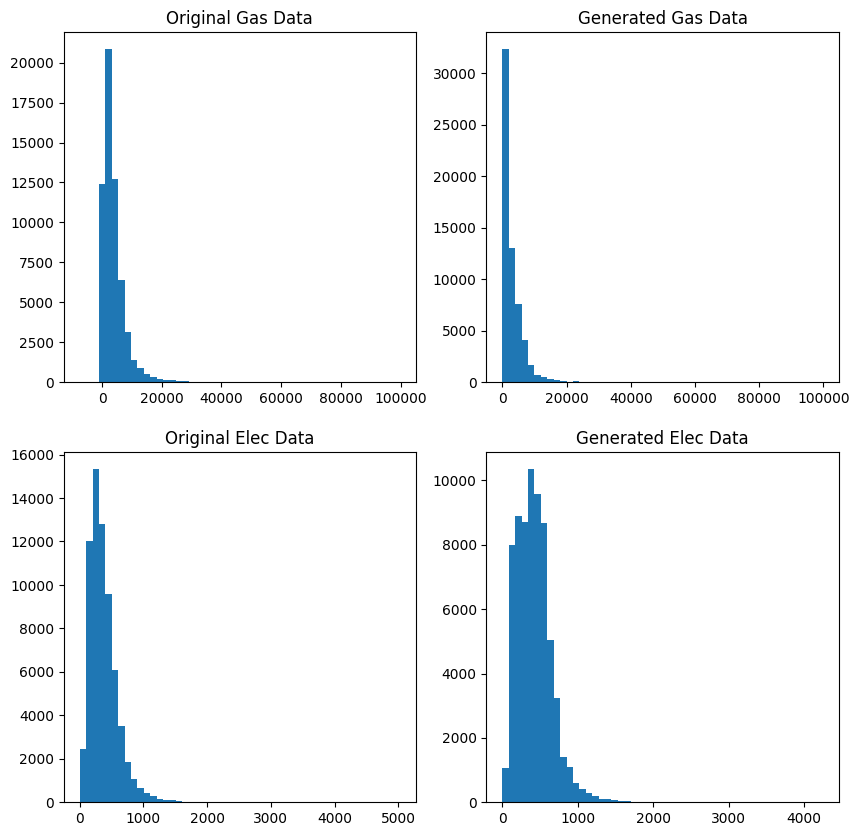

In [68]:
# now let's look at the distribution of the generated data in comparison to the original data
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].hist(orig_gas, bins=50)
axs[0, 0].set_title('Original Gas Data')
axs[0, 1].hist(gen_gas, bins=50)
axs[0, 1].set_title('Generated Gas Data')
axs[1, 0].hist(orig_elec, bins=50)
axs[1, 0].set_title('Original Elec Data')
axs[1, 1].hist(gen_elec, bins=50)
axs[1, 1].set_title('Generated Elec Data')
plt.show()

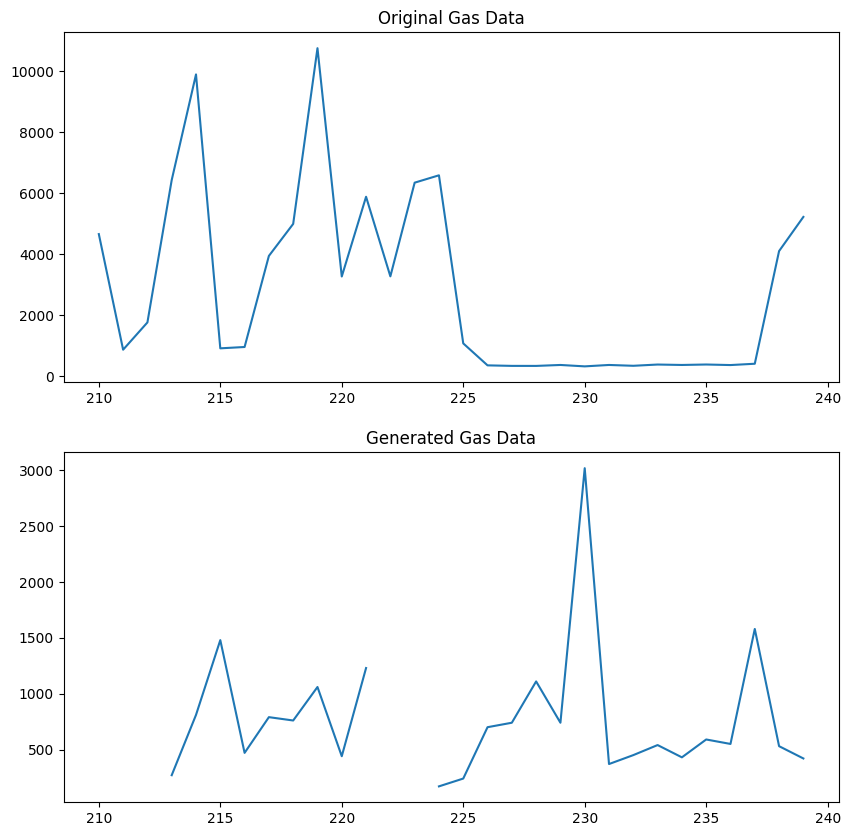

In [78]:
# let's start by just plotting the first 30 days of data
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(orig_gas[30*7:30*8])
axs[0].set_title('Original Gas Data')
axs[1].plot(gen_gas[30*7:30*8])
axs[1].set_title('Generated Gas Data')
plt.show()

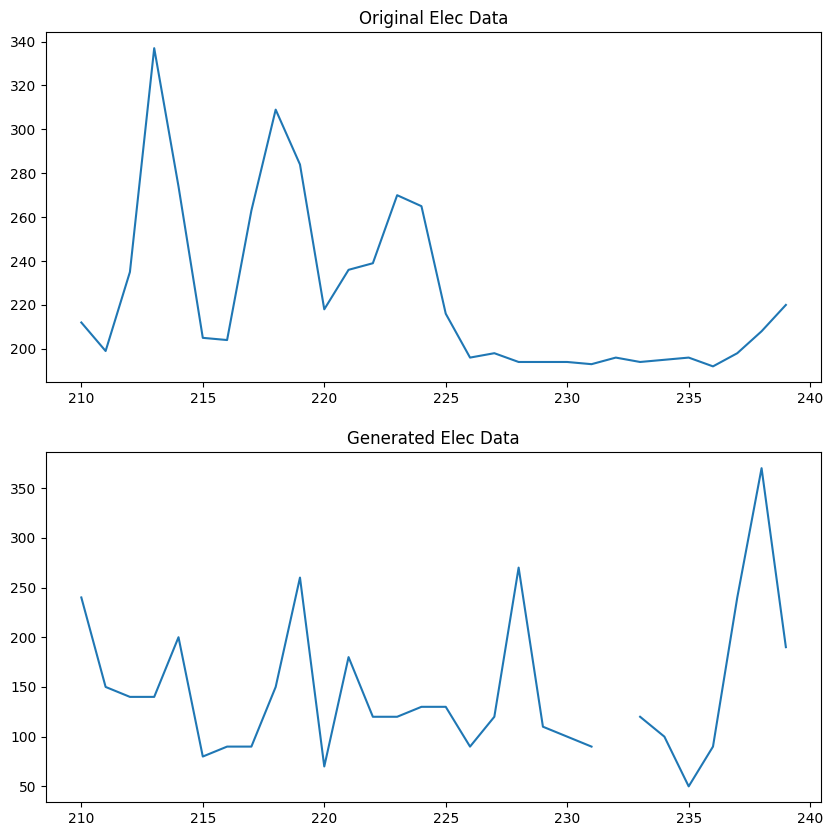

In [79]:
# let's do the same for electricity
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(orig_elec[30*7:30*8])
axs[0].set_title('Original Elec Data')
axs[1].plot(gen_elec[30*7:30*8])
axs[1].set_title('Generated Elec Data')
plt.show()